#### **Welcome to Assignment 5 on Deep Learning for Computer Vision.**
This notebook consists of two parts. In Part-1 you'll have to load pre-trained model and generate captions for a given input Image. Where, In Part-2 you'll learn about VAE, Transformers and Normalizing Flow.

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

**Acknowledgement:** This assignment is made possible with the help of this awesome pytorch tutorial: https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

### Part-1 : Image Captioning

**Important:** Download `pretrained_model.zip` and `vocap.zip` files into your notebook root folder before you start the assignment. These are share in the following link: https://drive.google.com/drive/folders/12O5lTaofxKHcOlYeEEfzVwidUeEdVdAK?usp=sharing

In [ ]:
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
!mv vocap.zip?dl=0 vocap.zip
!mv pretrained_model.zip?dl=0 pretrained_model.zip

--2021-04-11 17:23:38--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2021-04-11 17:23:39--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1eb5887f3c35cd28ed981bdad6.dl.dropboxusercontent.com/cd/0/inline/BMYqssOwlTmDEn76VK8CC7ZPX-L576CQvI0e6MJvQ4Xlw7eMQ5i7raKmxR7GiP9gaByUTLSvx8CDeJjiJ3jq2f1FW8HSfBnuZ9v_Ltgg078wurLQgKOELMvjRvj8dhlJ633557u2rdtSni-Xv-zHArMN/file# [following]
--2021-04-11 17:23:39--  https://uc1eb5887f3c35cd28ed981bdad6.dl.dropboxusercontent.com/cd/0/inline/BMYqssOwlTmDEn76VK8CC7ZPX-L576CQvI0e6MJvQ4Xlw7eMQ5i7raKmxR7Gi

In [ ]:
## Leave this cell untouched!
%%bash
mkdir models
unzip -q /content/pretrained_model.zip -d models 
unzip -q /content/vocap.zip -d models
wget http://farm6.staticflickr.com/5540/9036468623_61a0344eab_z.jpg -O image1.jpg
wget http://farm1.staticflickr.com/110/304953668_629cb610c1_z.jpg -O image2.jpg
wget http://farm2.staticflickr.com/1103/567229075_2cf8456f01_q.jpg -O image3.jpg
pip install torchtext

--2021-04-11 17:24:02--  http://farm6.staticflickr.com/5540/9036468623_61a0344eab_z.jpg
Resolving farm6.staticflickr.com (farm6.staticflickr.com)... 99.84.213.150, 2600:9000:210b:3600:0:5a51:64c9:c681, 2600:9000:210b:c200:0:5a51:64c9:c681, ...
Connecting to farm6.staticflickr.com (farm6.staticflickr.com)|99.84.213.150|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm6.staticflickr.com/5540/9036468623_61a0344eab_z.jpg [following]
--2021-04-11 17:24:02--  https://farm6.staticflickr.com/5540/9036468623_61a0344eab_z.jpg
Connecting to farm6.staticflickr.com (farm6.staticflickr.com)|99.84.213.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘image1.jpg’

     0K .......... .......... .......... .......... .......... 33.9M
    50K .......... .......... .......... .......... .......... 35.6M
   100K .......                                                 173M=0.003s

2021-04-11

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from PIL import Image
from torchvision import transforms 
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Question-1

Find out the caption generated by the model when an input image ("image3.jpg") is being fed to the encoder?

In [ ]:
#### YOUR CODE STARTS HERE ####
# Check availability of GPU and set the device accordingly
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device
#### YOUR CODE ENDS HERE ####

device(type='cuda')

In [ ]:
# this is a simple wrapper for dealing with the vocabulary! 
# this'll be automatically used when you load the provided vocabulary file
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        #### (5 Marks) YOUR CODE STARTS HERE ####
        # load the resnet152 network provided by torchvision
        resnet = models.resnet152(pretrained=True)
        # remove the last FC layer in the network
        modules = list(resnet.children())[:-1] 
        #define a sequential model with the modules obtained above
        self.resnet = nn.Sequential(*modules)
        # define a linear layer with out_features as embed_size
        self.linear =  nn.Linear(resnet.fc.in_features, embed_size)
        # define a 1d batch norm layer with embed_size as the number of features and a momentum of 0.01 
        self.bn =  nn.BatchNorm1d(embed_size, momentum=0.01)
        #### YOUR CODE ENDS HERE ####
    def forward(self, images):
        #### (1 mark) YOUR CODE STARTS HERE ####
        # calculate the forward pass in the order of base_model -> linear -> bn
        # reshape features, if necessary
        with torch.no_grad():
            features = self.resnet(images)
        features = self.linear(features.reshape(features.size(0), -1))
        features = self.bn(features)
        #### YOUR CODE ENDS HERE ####
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.max_seg_length = max_seq_length
        #### (2 marks) YOUR CODE STARTS HERE ####
        # define an embedding layer with vocab_size as the size of the dictionary
        # and embed_size as the size of each embedding
        self.embed = nn.Embedding(vocab_size, embed_size)
        # define a LSTM layer with embed_size, hidden_size, num_layers, set batch_first to True
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        # define a linear layer with out features as the vocab size
        self.linear = nn.Linear(hidden_size, vocab_size)
        #### YOUR CODE ENDS HERE ####

    def forward(self, features, captions, lengths):
        #### (2 marks) YOUR CODE STARTS HERE ####
        # get embeddings for the captions
        embeddings =  self.embed(captions)
        # concatenate the features with embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        #### YOUR CODE ENDS HERE ####
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


In [ ]:

def main(img_path):
    #### YOUR CODE STARTS HERE ####
    # Image preprocessing
    # (1 mark) define the transforms with normalization values: [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    transform = transforms.Compose([ 
         transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225)),
        ])
         # convert to a tensor
         # normalize 
   
    
    # load the vocaulary wrapper file
    with open('./models/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)

    ## (2 marks)
    # build encoder with a embed size of 256 (load it in eval mode)
    encoder = EncoderCNN(256)
    # build decoder with embed_size of 256, hidden_size of 512, vocab_size, 1 layer
    decoder =  DecoderRNN(256, 512, len(vocab), 1)
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    ## (2 marks)
    # load the pre-trained weights for encoder and decoder
    encoder.load_state_dict(torch.load('/content/models/encoder-5-3000.pkl'))
    decoder.load_state_dict(torch.load('/content/models/decoder-5-3000.pkl'))
    encoder.eval()
    decoder.eval()
    #### YOUR CODE ENDS HERE ####

    # Prepare an image
    image = Image.open(img_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    image = transform(image).unsqueeze(0)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(img_path)
    plt.imshow(np.asarray(image))

<start> a cat sitting on a chair next to a cat . <end>


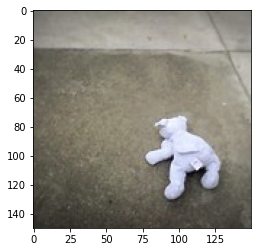

In [ ]:
main('image3.jpg')

### Part 2 : VAE, Transformers and Normalizing Flow

In part 2, you will learn the working of a Variational Autoencoder (VAE), Transformers and the basic principle behind Normalizing Flow.



--2021-04-11 18:36:40--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-11 18:36:40--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [         <=>        ]  33.20M  19.5MB/s    in 1.7s    

2021-04-11 18:36:42 (19.5 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

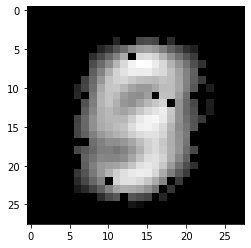

In [ ]:
'''Script to train a Variational AutoEncoder. Note : This Script is given for your reference, Not for
   Evaluation Purpose. You are encouraged to modify different part of the code and see how it affects'''

import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import os
from os.path import join as oj

!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz


out_dir = 'samples'
os.makedirs(out_dir, exist_ok=True)

class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r


class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class VAE(torch.nn.Module):
    latent_dim = 8

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(100, 8)
        self._enc_log_sigma = torch.nn.Linear(100, 8)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)


def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)


if __name__ == '__main__':

    input_dim = 28 * 28
    batch_size = 32
    transform = transforms.Compose(
        [transforms.ToTensor()])
    mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

    dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size,
                                             shuffle=True, num_workers=2)

    print('Number of samples: ', len(mnist))

    encoder = Encoder(input_dim, 100, 100)
    decoder = Decoder(8, 100, input_dim)
    vae = VAE(encoder, decoder)

    criterion = nn.MSELoss()

    optimizer = optim.Adam(vae.parameters(), lr=0.0001)
    l = None
    
    for epoch in range(25):
        for i, data in enumerate(dataloader, 0):
            inputs, classes = data
            inputs, classes = Variable(inputs.resize_(batch_size, input_dim)), Variable(classes)
            optimizer.zero_grad()
            dec = vae(inputs)
            ll = latent_loss(vae.z_mean, vae.z_sigma)
            loss = criterion(dec, inputs) + ll
            loss.backward()
            optimizer.step()
            l = loss.item()
        print(epoch, l)
    torch.save(vae.state_dict(), oj(out_dir, f'vae_final.pth'))

    plt.imshow(vae(inputs).data[0].numpy().reshape(28, 28), cmap='gray')
    plt.show(block=True)

#### Question 2:

Given an input image $x$ and parameters of an Encoder and Decoder of a Variational AutoEncoder(VAE) , Compute the variational Lower bound of $p(x)$, i.e. probability of $x$?


Hint: \begin{aligned} \log p_\theta(x) &\geq \mathbb{E}_{q_\phi(z|x)} \left[ \log p_\theta(x|z) \right] - \text{KL}\left[q_\phi(z|x) || p(z) \right] \end{aligned}
Note: Use torch.exp() library function in order to compute exponential.

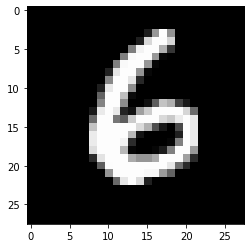

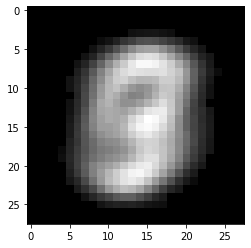

ELBO Loss is:  tensor(0.0671)


In [ ]:
# Load a given Pretrained VAE model ("vae_final.pth") and compute lower bound of p(x), given input image x

import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
import os
from os.path import join as oj

torch.manual_seed(1)
np.random.seed(1)

out_dir = 'samples'
os.makedirs(out_dir, exist_ok=True)

#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz


class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r


class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class VAE(torch.nn.Module):
    latent_dim = 8

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(100, 8)
        self._enc_log_sigma = torch.nn.Linear(100, 8)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)


def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)


if __name__ == '__main__':

    transform = transforms.Compose(
        [transforms.ToTensor()])
    mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

    dataloader = torch.utils.data.DataLoader(mnist, batch_size=1,
                                             shuffle=True, num_workers=2)
    for input in dataloader:
      im0,_ = input 
      break
    
    # Visualize the input image

    plt.imshow(im0.numpy().reshape(28, 28), cmap='gray')
    plt.show(block=True)

    ## Find out P(im0) >= ? i.e. Lower bound of Probability of im0
    ### YOUR CODE STARTS HERE ###

    # Define input dimension 
    input_dim = 28*28
     # initialize encoder, decoder and vae objects (3 marks)
    encoder = Encoder(input_dim, 100, 100)
    decoder = Decoder(8, 100, input_dim)
    vae = VAE(encoder, decoder)
    # load the given pre-trained vae weights (1 mark)
    vae.load_state_dict(torch.load('/content/samples/vae_final.pth'))
    vae.eval()
    with torch.no_grad():
        # Use MSELoss to compute reconstuction error (1 mark)
        im0=im0.view(1,input_dim)
        im0.to(device)
        criterion=nn.MSELoss()
        recons_loss = criterion(vae(im0),im0)
        # Do the forward pass with the given input image im0 
        # and then get the reconstructed image (total 2+2+1 marks)
        out = vae(im0)
        plt.imshow(out.data[0].numpy().reshape(28, 28), cmap='gray')
        plt.show(block=True)
        print('ELBO Loss is: ',recons_loss+latent_loss(vae.z_mean, vae.z_sigma))
        # Compute the varionational lowerbound (ELBO) (3 marks)

    ### YOUR CODE ENDS HERE ###
    

#### Question-3 : Transformer

This question is based on official PyTorch tutorial [Sequence-to-sequence modeling with nn.Transformer and TorchText](https://pytorch.org/tutorials/beginner/transformer_tutorial.html). Unlike the tutorial you'll have to code the encoding layer from scratch.

**Note:**  We use a different set of hyper-parameters from the ones used in tutorial, ensure you only use the code in this notebook while reporting the answers

Report the final validation loss on the given setup?

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [ ]:
class CustomEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=128, dropout=0.1, activation="relu"):
        super(CustomEncoderLayer, self).__init__()
        #### (4 marks) YOUR CODE STARTS HERE ####
        # define a multi head attention layer d_model, nhead and dropout
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # define a linear layer with 256 as the number of output features
        self.linear1 = nn.Linear(d_model, 256)
        # define a dropout layer using the passed value
        self.dropout = nn.Dropout(dropout)
       # define a linear layer with dim_feedforward as the number of output features
        self.linear2 =  nn.Linear(256,dim_feedforward)
        # define a linear layer with d_model as the number of output features
        self.linear3 = nn.Linear(dim_feedforward,d_model)
        # define a normalization layer (not batch and instance norm) with d_model as the normalized shape
        self.norm1 = nn.LayerNorm(d_model)
        # define a normalization layer (not batch and instance norm) with d_model as the normalized shape
        self.norm2 = nn.LayerNorm(d_model)
        # define a dropout layer using the passed value
        self.dropout1 = nn.Dropout(dropout)
        # define a dropout layer using the passed value
        self.dropout2 = nn.Dropout(dropout)
        #### YOUR CODE ENDS HERE ####
        self.activation = nn.ReLU()
        
    def forward(self, src, src_mask, src_key_padding_mask):

        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        #### (3 marks) YOUR CODE STARTS HERE ####
        # use dropout1 of src2 and to src
        src =  src + self.dropout1(src2)
        # use the norm1 layer on src
        src = self.norm1(src)
        # use linear1 on src along with activation
        src2 = self.activation(self.linear1(src))
        # use dropout on src2
        src2 = self.dropout(src2)
        # use linear2 on src2 along with activation
        src2 = self.linear2(src2)
        # use linear3 on src2
        src2 = self.linear3(src2)
        # use dropout2 on src2 and add it to src
        src = src + self.dropout2(src2)
        # use norm2 on src
        src = self.norm2(src)
        #### YOUR CODE ENDS HERE ####
        return src

In [ ]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = CustomEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
import torchtext
from torchtext.data.utils import get_tokenizer
TEXT = torchtext.legacy.data.Field(tokenize=get_tokenizer("spacy"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.legacy.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

In [ ]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [ ]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 100 # embedding dimension
nhid = 100 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 1 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train():
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    ntokens = len(TEXT.vocab.stoi)
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        if data.size(0) != bptt:
            src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = 200
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    ntokens = len(TEXT.vocab.stoi)
    src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            if data.size(0) != bptt:
                src_mask = model.generate_square_subsequent_mask(data.size(0)).to(device)
            output = eval_model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

In [ ]:
best_val_loss = float("inf")
epochs = 1 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train()
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


| epoch   1 |   200/ 3195 batches | lr 1.00 | ms/batch 10.58 | loss  6.86 | ppl   950.52
| epoch   1 |   400/ 3195 batches | lr 1.00 | ms/batch 10.28 | loss  6.31 | ppl   550.48
| epoch   1 |   600/ 3195 batches | lr 1.00 | ms/batch 10.22 | loss  6.12 | ppl   457.02
| epoch   1 |   800/ 3195 batches | lr 1.00 | ms/batch 10.25 | loss  6.00 | ppl   404.37
| epoch   1 |  1000/ 3195 batches | lr 1.00 | ms/batch 10.28 | loss  6.02 | ppl   411.20
| epoch   1 |  1200/ 3195 batches | lr 1.00 | ms/batch 10.31 | loss  5.96 | ppl   389.38
| epoch   1 |  1400/ 3195 batches | lr 1.00 | ms/batch 10.27 | loss  5.87 | ppl   355.95
| epoch   1 |  1600/ 3195 batches | lr 1.00 | ms/batch 10.29 | loss  5.76 | ppl   318.70
| epoch   1 |  1800/ 3195 batches | lr 1.00 | ms/batch 10.34 | loss  5.80 | ppl   331.68
| epoch   1 |  2000/ 3195 batches | lr 1.00 | ms/batch 10.33 | loss  5.80 | ppl   328.88
| epoch   1 |  2200/ 3195 batches | lr 1.00 | ms/batch 10.39 | loss  5.73 | ppl   309.00
| epoch   1 |  2400/ 

#### Question 4 (Optional):

Compute "Transformed" Probability Density Function (pdf) of $\mathbf{y}$, i.e.  $q_1(\mathbf{y})$. Where, $\mathbf{y}$ is obtained from $\mathbf{z}$ via an invertible transformation $f$ as shown below:

Let $\mathbf{z}\sim q_0(\mathbf{z})$ where $q_0(\mathbf{z}) = \mathcal{N}(\mathbf{z};\mathbf{0},\mathbf{I})$.  
Let $f(\mathbf{z})$ be an invertible transformation given by 
$$ \mathbf{y} = f(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^\top\mathbf{z}+b)$$
The pdf of $\mathbf{y}$ is given by
$q_1(\mathbf{y})$

Find out the mean and standard deviation of $q_1(\mathbf{y})$; given the values of $q_0(\mathbf{z})$ , $\mathbf{f}$ and all the parameters required to compute $f(\mathbf{z})$?


Hint: 
$$q_1(\mathbf{y}) = q_0(\mathbf{z})\left|\det\frac{\partial f}{\partial \mathbf{z}}\right|^{-1}$$

$\left|\det\frac{\partial f}{\partial \mathbf{z}}\right|$ can be computed as follows
$$ \psi(\mathbf{z}) = h'(\mathbf{w}^\top\mathbf{z}+b)\mathbf{w} $$
$$\left|\det\frac{\partial f}{\partial \mathbf{z}}\right| = |1 + \mathbf{u}^\top\psi(\mathbf{z})|$$
Here, we set $h(x)=\tanh(x)$ which gives us $h'(x)=(1-\tanh^2(x))$

Note: In code "det_J(z)" is used to represent  the following quantity: $$\left|\det\frac{\partial f}{\partial \mathbf{z}}\right|$$

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy.linalg as LA

np.random.seed(1)

## Define Parameters of Invertible transformation
w = np.array([5., 0])
u = np.array([3., 0])
b = 0

## Define and Instantiate probability Density function q0(z)

def mvn_pdf(X, mu=np.array([[0,0]]), sig=np.eye(2)):
    sqrt_det_2pi_sig = np.sqrt(2 * np.pi * LA.det(sig))
    sig_inv = LA.inv(sig)
    X = X[:, None, :] - mu[None, :, :]
    return np.exp(-np.matmul(np.matmul(X, np.expand_dims(sig_inv, 0)), (X.transpose(0, 2, 1)))/2)/sqrt_det_2pi_sig

r = np.linspace(-3,3,1000)
z = np.array(np.meshgrid(r, r)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])
q0 = mvn_pdf(z)


### YOUR CODE STATRS HERE ###

## Functions required to compute q1(y)..
"""
## (1 mark) Define function to compute h(x)
def h(x):
    return np.tanh(x)

## (1 mark) Define function to compute h_prime(x)
def h_prime(x):
    return 1 - np.tanh(x) ** 2

## (2 mark) Define function to compute y = f(z)
def f(z):
    return z + np.dot(h(np.dot(z, w) + b).reshape(-1,1), u.reshape(1,-1))

## (2 marks) Define function to compute |det (df/dz)|

def det_J(z):
    psi = h_prime(np.dot(z, w) + b).reshape(-1,1) * w
    det = np.abs(1 + np.dot(psi, u.reshape(-1,1)))
    return det
## (1 mark) Actual computation of Transformed Probability Density Function of y , i.e. q1(y) = q0 / |det (df/dz)|
q1=q0/np.abs(det_J(z)+1e-5)
### YOUR CODE ENDS HERE ###

print ("Mean of q1(y): ",np.mean(q1))
print ("Standard Deviation of q1(y): ",np.std(q1))
"""